In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import keras
import tensorflow as tf
import nltk
import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from nltk.corpus import stopwords
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
true=pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
fake=pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')

# EDA

In [3]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [4]:
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [5]:
true.shape

(21417, 4)

In [6]:
fake.shape

(23481, 4)

In [7]:
true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [10]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [11]:
true['target']=1
fake['target']=0

In [12]:
news_data=pd.concat([true,fake],ignore_index=True,sort=False)

In [13]:
news_data.head(5)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
news_data.shape

(44898, 5)

Text(0.5, 1.0, 'Data distribution of fake and real data')

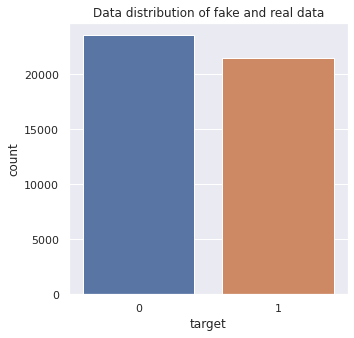

In [15]:
plt.figure(figsize=(5,5))
sns.set(style='darkgrid')
sns.countplot(news_data.target)
plt.title('Data distribution of fake and real data')

Text(0, 0.5, 'total no count')

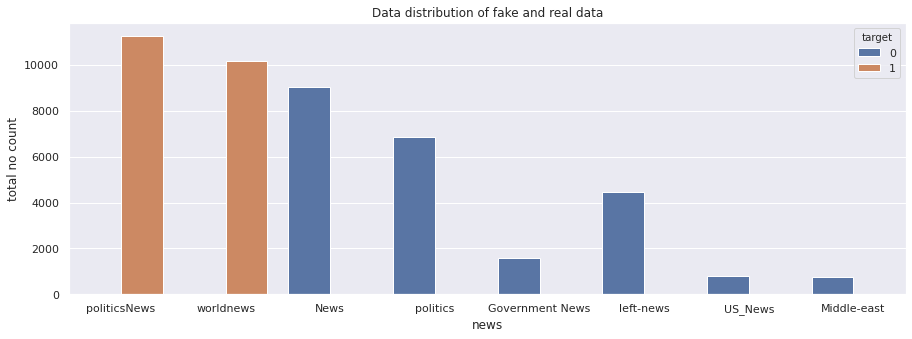

In [16]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
plt.title("Data distribution of fake and real data")
sns.countplot(x='subject',data=news_data,hue='target')
plt.xlabel('news')
plt.ylabel('total no count')

In [17]:
news_data['text']=news_data['title']+''+news_data['text']

In [18]:
data=news_data[['text','target']]

# Tokenization:-
Tokenization is task splitting text into meaningfull segment called tokens.the input to tokenizer is a unicode text and the output is doc object

In [19]:
spacy_tok = spacy.load('en_core_web_sm')
sample_data=data.text[50]
sample_data

'Trump urges Congress to pass short-term spending billWASHINGTON (Reuters) - U.S. President Donald Trump called on the Republican Congress to pass a short-term government spending bill later on Thursday to avoid a shutdown when current funding expires at midnight on Friday. Republicans in the House of Representatives have unveiled a stopgap spending bill that would allow the government to stay open at current funding levels. “Pass the C.R. (continuing resolution) TODAY and keep our Government OPEN!” Trump wrote in a post on Twitter.  '

In [20]:
parsed_data=spacy_tok(sample_data)
parsed_data

Trump urges Congress to pass short-term spending billWASHINGTON (Reuters) - U.S. President Donald Trump called on the Republican Congress to pass a short-term government spending bill later on Thursday to avoid a shutdown when current funding expires at midnight on Friday. Republicans in the House of Representatives have unveiled a stopgap spending bill that would allow the government to stay open at current funding levels. “Pass the C.R. (continuing resolution) TODAY and keep our Government OPEN!” Trump wrote in a post on Twitter.  

# #Here we visualize the data differnent method

In [21]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2020-12-25 09:37:14--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py’

explacy.py          100%[===================>]   6.73K  --.-KB/s    in 0s      

2020-12-25 09:37:14 (53.3 MB/s) - ‘explacy.py’ saved [6896/6896]



In [22]:
import explacy
explacy.print_parse_info(spacy_tok, 'Trump urges Congress to pass short-term spending billWASHINGTON (Reuters)')

Dep tree       Token          Dep type Lemma          Part of Sp
────────────── ────────────── ──────── ────────────── ──────────
           ┌─► Trump          nsubj    trump          ADJ       
┌┬─────────┼── urges          ROOT     urge           VERB      
││         └─► Congress       dobj     Congress       PROPN     
││         ┌─► to             aux      to             PART      
│└─►┌──────┴── pass           xcomp    pass           VERB      
│   │     ┌──► short          amod     short          ADJ       
│   │     │┌─► -              punct    -              PUNCT     
│   │  ┌─►└┴── term           compound term           NOUN      
│   │  │   ┌─► spending       compound spending       NOUN      
│   └─►└┬──┴── billWASHINGTON dobj     billWASHINGTON PROPN     
│       │  ┌─► (              punct    (              PUNCT     
│       └─►└── Reuters        appos    Reuters        PROPN     
└────────────► )              punct    )              PUNCT     


In [23]:
 explacy.print_parse_info(spacy_tok,data.text[1])

Dep tree                          Token              Dep type  Lemma              Part of Sp
───────────────────────────────── ────────────────── ───────── ────────────────── ──────────
                              ┌─► U.S.               compound  U.S.               PROPN     
                   ┌┬┬────────┴── military           ROOT      military           NOUN      
                   │││        ┌─► to                 aux       to                 PART      
                   ││└─►┌─────┴── accept             relcl     accept             VERB      
                   ││   │     ┌─► transgender        compound  transgender        NOUN      
                   ││   └─►┌──┴── recruits           dobj      recruit            NOUN      
                   ││      └─►┌── on                 prep      on                 ADP       
                   ││         └─► Monday             pobj      Monday             PROPN     
                   │└───────────► :                  punct     :      

After tokenization we can parse tag variety of part of speech to paragraph text.Spacy uses stats models in background to predict which tag will go each word based on the context
Lemmatization:-it is the process of extracting form of the word

In [24]:
tokenize=pd.DataFrame()
for i,token in enumerate(parsed_data):
    tokenize.loc[i,'text']=token.text
    tokenize.loc[i,'lemma']=token.lemma_
    tokenize.loc[i,'pos']=token.pos_
    tokenize.loc[i,'dep']=token.dep_
    tokenize.loc[i, 'is_punctuation'] = token.is_punct
    tokenize.loc[i, 'shape'] = token.shape_
    tokenize.loc[i, 'is_alpha'] = token.is_alpha
    tokenize.loc[i, 'is_stop'] = token.is_stop
tokenize[:5]

,text,lemma,pos,dep,is_punctuation,shape,is_alpha,is_stop
0,Trump,trump,ADJ,nsubj,False,Xxxxx,True,False
1,urges,urge,VERB,ROOT,False,xxxx,True,False
2,Congress,Congress,PROPN,dobj,False,Xxxxx,True,False
3,to,to,PART,aux,False,xx,True,True
4,pass,pass,VERB,xcomp,False,xxxx,True,False


visulization through displacy

In [25]:
spacy.displacy.render(parsed_data, style='ent')

In [26]:
spacy.explain('GPE') # to explain POS tag

'Countries, cities, states'

Dependency parsing
Syntactic Parsing or Dependency Parsing is process of identifyig sentenses and assigning a syntactic structure to it. As in Subject combined with object makes a sentence. Spacy provides parse tree which can be used to generate this structure.
Sentense Boundry Detection

In [27]:
sentence_spans = list(parsed_data.sents)
sentence_spans

[Trump urges Congress to pass short-term spending billWASHINGTON (Reuters),
 - U.S. President Donald Trump called on the Republican Congress to pass a short-term government spending bill later on Thursday to avoid a shutdown when current funding expires at midnight on Friday.,
 Republicans in the House of Representatives have unveiled a stopgap spending bill that would allow the government to stay open at current funding levels.,
 “Pass the C.R. (continuing resolution) TODAY and keep our Government OPEN!”,
 Trump wrote in a post on Twitter.  ]

In [28]:
from spacy import displacy
displacy.render(parsed_data, style='dep', jupyter=True,options={'distance': 140})

In [29]:
options = {'compact': True, 'bg': 'violet','distance': 140,
           'color': 'white', 'font': 'Trebuchet MS'}
displacy.render(parsed_data,jupyter=True, style='dep', options=options)

In [30]:
data=data[:1000]

In [31]:
## Get the Independent Features
X=data['text']
y=data['target']

In [32]:
X.shape

(1000,)

In [33]:
y.shape

(1000,)

In [34]:
#here we take vocabulry size
voc_size=5000

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
X.shape

(1000,)

In [37]:
ps=PorterStemmer()
corpus=[]
for i in range(0,len(X)):
    print(i)
    news=re.sub('[^a-zA-Z]',' ',data['text'][i])
    news=news.lower()
    news=news.split()
    news=[ps.stem(word) for word in news if not word in stopwords.words('english')]
    news=' '.join(news)
    corpus.append(news)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [38]:
corpus

['u budget fight loom republican flip fiscal scriptwashington reuter head conserv republican faction u congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint keep sharp pivot way among republican u repres mark meadow speak cb face nation drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici even novemb congression elect campaign approach republican seek keep control congress presid donald trump republican want big budget increas militari spend democrat also want proport increas non defens discretionari spend program support educ scientif research infrastructur public health environment protect trump administr alreadi will say go increas non defens discretionari spend percent meadow chairman small influenti hous freedom caucu said program democrat say enough need give govern pay rais percent fiscal conserv see rational eventu run peopl money sai

In [39]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[482,
  2161,
  3731,
  1845,
  725,
  4261,
  870,
  2986,
  4247,
  2281,
  3286,
  725,
  1268,
  482,
  4566,
  2463,
  2039,
  2428,
  3608,
  347,
  1387,
  3652,
  3243,
  3528,
  3456,
  870,
  3286,
  433,
  2334,
  2161,
  2106,
  763,
  1135,
  3563,
  3364,
  2617,
  725,
  482,
  1168,
  1709,
  2222,
  2225,
  4360,
  607,
  347,
  1473,
  1261,
  2252,
  2169,
  770,
  4939,
  3690,
  945,
  2041,
  582,
  778,
  4453,
  4939,
  969,
  4054,
  3564,
  2169,
  2161,
  3731,
  4031,
  3274,
  4073,
  3361,
  155,
  225,
  2482,
  4432,
  461,
  3141,
  4256,
  725,
  3195,
  763,
  1343,
  4566,
  4495,
  2003,
  2732,
  725,
  3706,
  4060,
  2161,
  30,
  3137,
  770,
  2631,
  2422,
  3706,
  3311,
  30,
  4254,
  4530,
  2069,
  770,
  1534,
  3861,
  2418,
  88,
  155,
  1974,
  3178,
  2594,
  3553,
  4212,
  2732,
  3935,
  4599,
  1079,
  1665,
  768,
  30,
  4254,
  4530,
  2069,
  770,
  2960,
  2222,
  2034,
  4468,
  2192,
  1119,
  1031,
  3915,
  4641,
  153

In [40]:
#Embedding the text data
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[1037 4137 4264 ... 1358 2463 1037]
 [1535 2212 1070 ... 4023 4887  329]
 [1106 3364 3802 ... 4748 2788 4641]
 ...
 [1367 3487 3328 ... 1601 2228 3254]
 [2845 2269 4706 ... 2297 3902 3929]
 [4518 3137 4522 ... 3732 2104 3588]]


In [41]:
embedded_docs[0]

array([1037, 4137, 4264, 2471, 2841, 1686, 3441, 2790, 2060, 4137, 3850,
       1560, 1917, 1334, 2732, 3935, 1516, 1358, 2463, 1037], dtype=int32)

In [42]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(1000))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 1000)              4164000   
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 4,365,001
Trainable params: 4,365,001
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
len(embedded_docs),y.shape

(1000, (1000,))

In [44]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [45]:
X_final.shape

(1000, 20)

In [46]:
y_final.shape

(1000,)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=0.20, random_state=0)

In [48]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
13/13 [==============================] - 7s 575ms/step - loss: 0.1759 - accuracy: 0.9600 - val_loss: 1.1262e-15 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 7s 517ms/step - loss: 2.4375e-16 - accuracy: 1.0000 - val_loss: 2.8527e-17 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 7s 509ms/step - loss: 1.8922e-17 - accuracy: 1.0000 - val_loss: 1.2919e-17 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 7s 517ms/step - loss: 1.1491e-17 - accuracy: 1.0000 - val_loss: 1.0397e-17 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 7s 516ms/step - loss: 1.0053e-17 - accuracy: 1.0000 - val_loss: 9.7783e-18 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 7s 545ms/step - loss: 9.6854e-18 - accuracy: 1.0000 - val_loss: 9.6119e-18 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 7s 523ms/step - loss: 9.5854e-18 - accuracy: 1.0000 

In [49]:
y_pred=model.predict_classes(X_test)

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
confusion_matrix(y_test,y_pred)

array([[200]])

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

1.0

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [54]:
## Creating bidirectional 
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.4))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
13/13 [==============================] - 1s 89ms/step - loss: 0.5606 - accuracy: 0.9538 - val_loss: 0.1296 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 0s 34ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 5.4996e-06 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 0s 30ms/step - loss: 4.7087e-06 - accuracy: 1.0000 - val_loss: 1.3788e-06 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 0s 30ms/step - loss: 1.8297e-06 - accuracy: 1.0000 - val_loss: 9.2449e-07 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 0s 30ms/step - loss: 1.4063e-06 - accuracy: 1.0000 - val_loss: 8.2079e-07 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 0s 29ms/step - loss: 1.3680e-06 - accuracy: 1.0000 - val_loss: 7.8987e-07 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 0s 29ms/step - loss: 1.2341e-06 - accuracy: 1.0000 - val_loss: 7.7

In [56]:
y_pred1=model1.predict_classes(X_test)

In [57]:
confusion_matrix(y_test,y_pred1)

array([[200]])

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

1.0

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

1.0

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

